In [1]:
from google.colab import drive
drive.mount('/content/drive/')

filepath = "/content/drive/My Drive/winter2022/Projects/SpamReviewsDetector/data"

"""
    0    ---->  Not a spam review

    1    ---->  spam review
"""

Mounted at /content/drive/


'\n    0    ---->  Not a spam review\n\n    1    ---->  spam review\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import wordcloud as WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('popular', quiet=True)
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import gensim
import pickle

In [ ]:
data = pd.read_csv(f"{filepath}/AmazonReviews.csv")
df = data[['review', 'class']]
#Reduce the dataset to 50k reviews

real_review = df[df['class']==0]
spam_review = df[df['class']==1]
data = pd.concat([real_review.sample(25000), spam_review.sample(25000)], ignore_index=True)
data = shuffle(data).reset_index(drop=True)

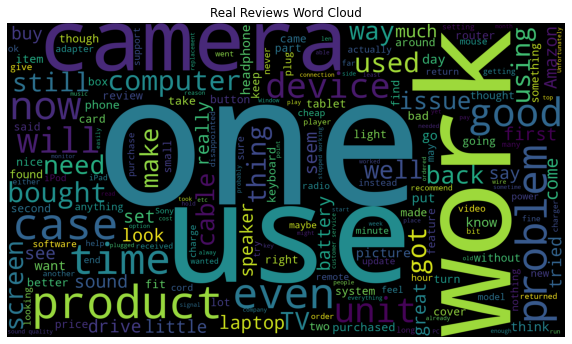

In [ ]:
real_reviews = data[data['class']==0]
real_full_text = ' '.join(real_reviews['review'].tolist())
fake_reviews = data[data['class']==1]
fake_full_text = ' '.join(fake_reviews['review'].tolist())

wc = WordCloud.WordCloud(width=1920, height=1080).generate(real_full_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.title("Real Reviews Word Cloud")
plt.show()

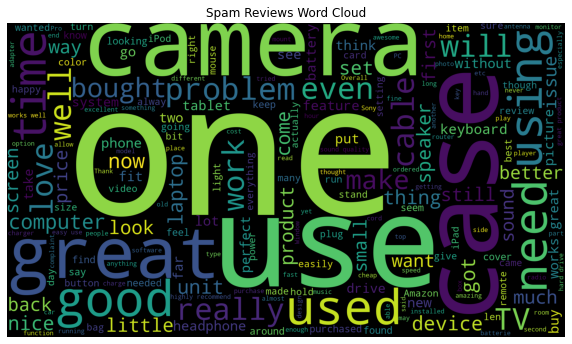

In [ ]:
wc = WordCloud.WordCloud(width=1920, height=1080).generate(fake_full_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.title("Spam Reviews Word Cloud")
plt.show()

In [ ]:
#Do cleaning of a review
def normalizer(review):
  alpha_words = re.sub("[^a-zA-Z]", " ", review)
  alpha_words = alpha_words.lower()
  clean = [itm.strip() for itm in alpha_words.split()]
  clean = [word for word in clean if word!=""]
  #clean = [word for word in alpha_words if word not in stopwords.words('english')]
  #lemmas = [wordnet_lemmatizer.lemmatize(w) for w in clean]
  #lemmas = ' '.join(lemmas)
  clean = ' '.join(clean)
  return clean

In [ ]:
#Shuffle the original dataset in order to minimise variance and ensure that the ...
#model will generalise well to new, unseen data points
data = shuffle(data).reset_index(drop=True)
data['review'] = data['review'].apply(normalizer)

# 1. Spam classification using LSTM

In [ ]:
X = [itm.split() for itm in data['review'].tolist()]
y = data['class'].values

In [ ]:
#train a word2vec model
dim = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=dim, window=10, min_count=1)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

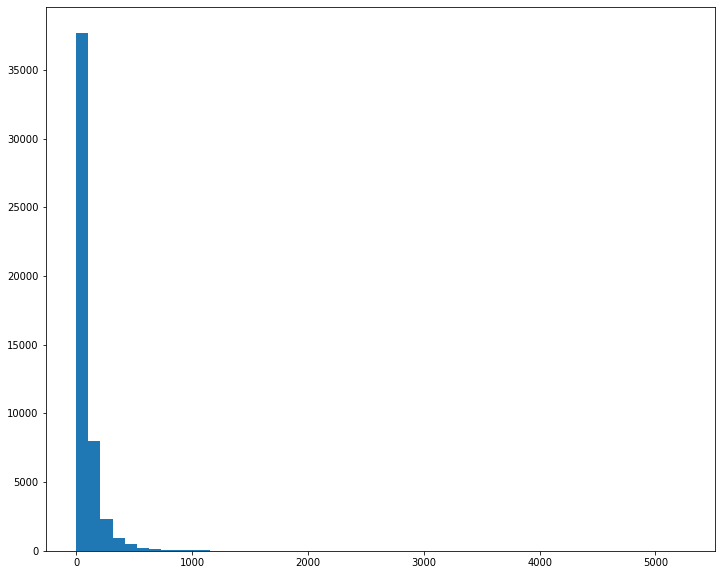

In [ ]:
#Check the most common review length
fig = plt.figure(figsize=(12,10))
plt.hist([len(x) for x in X], bins = 50)
plt.show()

In [ ]:
#From the histogram above, most reviews a shorter than 500 words
max_len = 300
X = pad_sequences(X, maxlen=max_len)

In [ ]:
#Make vocab size one number higher than the largest tokenized word index since 
#Tokenized word indexes start at 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_embeddings(model, num_wi=vocab_size, dim=dim):
  weight_matrix = np.zeros((num_wi, dim))

  for word, i in tokenizer.word_index.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix


In [ ]:
embedding_vectors = get_embeddings(w2v_model)

In [ ]:
#Create an LSTM Neural Network

model = Sequential()
model.add(Embedding(vocab_size, output_dim=dim, weights=[embedding_vectors], 
                    input_length=max_len, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 100)          4561400   
                                                                 
 lstm_8 (LSTM)               (None, 128)               117248    
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,678,777
Trainable params: 117,377
Non-trainable params: 4,561,400
_________________________________________________________________


In [4]:
!pip install keras_pickle_wrapper -q
from keras_pickle_wrapper import KerasPickleWrapper

In [ ]:
mw = KerasPickleWrapper(model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [ ]:
history = mw().fit(X_train, y_train, validation_split=0.25, epochs=3, batch_size=16)

Epoch 1/3
1875/1875 [==============================] - 35s 18ms/step - loss: 0.4460 - acc: 0.7909 - val_loss: 0.3818 - val_acc: 0.8266
Epoch 2/3
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3387 - acc: 0.8543 - val_loss: 0.3164 - val_acc: 0.8641
Epoch 3/3
1875/1875 [==============================] - 33s 17ms/step - loss: 0.2868 - acc: 0.8796 - val_loss: 0.3076 - val_acc: 0.8736


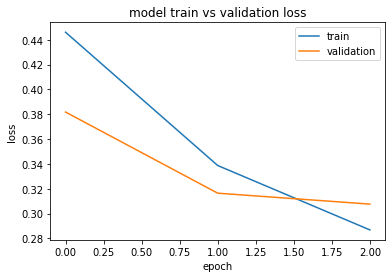

In [ ]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#Save the figure first
plt.savefig(f"{filepath}/../plots/train_vs_validation_LSTM.png")
plt.show()

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)
accuracy_score(y_test, y_pred)

0.8651

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      5000
           1       0.85      0.89      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
#Test custom input
x = ["Yo, this is not a real one!"]

x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=max_len)

(model.predict(x) >= 0.5).astype(int)[0][0]

0

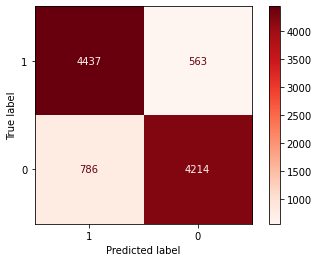

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot(cmap='Reds')
plt.show()

# 2. Spam classification using BERT

In [5]:
# Make sure I use a corresponding tensorflow version
!pip install -U tensorflow-text==2.7.0 -q

     |████████████████████████████████| 4.9 MB 9.9 MB/s 


In [6]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import numpy as np

In [7]:
# downloading preprocessing files and model
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

In [ ]:
# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

# compiling our model
model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
#Wrap the model to make it pickable
mw = KerasPickleWrapper(model)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(data['review'], data['class'], test_size=0.2, stratify = data['class'])

In [ ]:
history = mw().fit(X_train, y_train, validation_split=0.25, epochs = 10)

Epoch 1/10
938/938 [==============================] - 287s 291ms/step - loss: 0.6193 - accuracy: 0.6587 - precision: 0.6597 - recall: 0.6581 - val_loss: 0.5487 - val_accuracy: 0.7548 - val_precision: 0.8107 - val_recall: 0.6614
Epoch 2/10
938/938 [==============================] - 271s 289ms/step - loss: 0.5445 - accuracy: 0.7368 - precision: 0.7407 - recall: 0.7302 - val_loss: 0.5079 - val_accuracy: 0.7669 - val_precision: 0.7466 - val_recall: 0.8041
Epoch 3/10
938/938 [==============================] - 270s 288ms/step - loss: 0.5190 - accuracy: 0.7515 - precision: 0.7560 - recall: 0.7439 - val_loss: 0.4861 - val_accuracy: 0.7812 - val_precision: 0.7831 - val_recall: 0.7746
Epoch 4/10
938/938 [==============================] - 270s 288ms/step - loss: 0.5041 - accuracy: 0.7593 - precision: 0.7647 - recall: 0.7503 - val_loss: 0.4800 - val_accuracy: 0.7772 - val_precision: 0.7471 - val_recall: 0.8345
Epoch 5/10
938/938 [==============================] - 270s 288ms/step - loss: 0.4977 - a

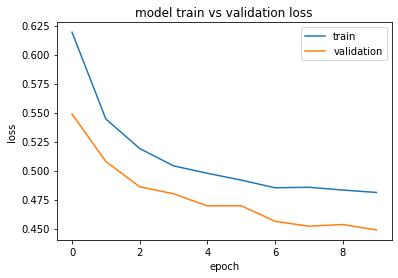

In [ ]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#Save the figure first
plt.savefig(f"{filepath}/../plots/train_vs_validation_BERT.png")
plt.show()

In [ ]:
y_pred = (mw().predict(X_test) >= 0.5).astype(int)
accuracy_score(y_test, y_pred)

0.7978

In [ ]:
#Test custom input
x = ["Ayoy!"]

(mw().predict(x) >= 0.5).astype(int)[0][0]

1

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      5000
           1       0.79      0.80      0.80      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



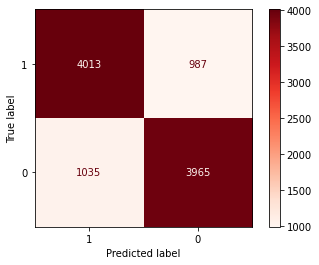

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot(cmap='Reds')
plt.show()

# Spam Classification with Logistic Regression

In [ ]:
#Do Lemmatization of a tweet
def normalizer(tweet):
  tweet = re.sub(r"@\S+|https?://\S+", "", tweet).strip()
  alpha_words = re.sub("[^a-zA-Z]", " ", tweet)
  alpha_words = alpha_words.lower()
  alpha_words = alpha_words.split()
  clean = [word.strip() for word in alpha_words if word not in stopwords.words('english')]
  lemmas = [wordnet_lemmatizer.lemmatize(w) for w in clean]
  lemmas = ' '.join(lemmas)
  return lemmas

In [ ]:
X = data['review'].copy()
X = X.apply(normalizer)
y = data['class']

In [ ]:
#Remove empty documents after Normalization
empty_docs_idx = [i for i,w in enumerate(X) if w==""]
for i in empty_docs_idx:
  del X[i]
  del y[i]

### a) Word Embedding with TfidfVectorizer

In [ ]:
#convert each document to a vector of word counts
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,y, test_size=0.2)

In [ ]:
lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [ ]:
#Find the best estimators with GridSearch
params = {'C': np.logspace(-3,3,7), "penalty":["l2"]}
gs_clf = GridSearchCV(lr_model, params, n_jobs=-1, cv=10)
gs_clf = gs_clf.fit(X_train, y_train)
lr_model = gs_clf.best_estimator_

In [ ]:
y_pred = lr_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_test, y_pred)*100)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5032
           1       0.84      0.84      0.84      4968

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



 Accuracy score  =  84.15


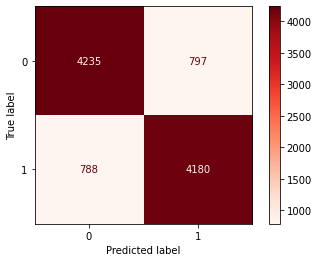

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Reds')
plt.show()

# Spam Classification with RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred=model.predict(X_test)
accuracy_score(y_test,y_pred)*100

81.54

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      5002
           1       0.82      0.79      0.81      4998

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



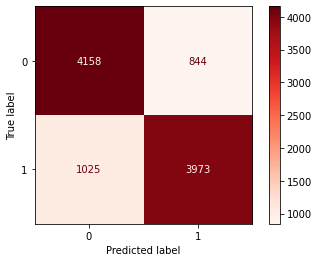

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Reds')
plt.show()

In [ ]:
pickl = {'tokenizer': tokenizer,
         'maxlen': max_len,
         'model': mw
         }
pickle.dump(pickl, open(f"{filepath}/../models/spam_classifier.p", "wb"))

In [ ]:
#!pip install keras-pickle-wrapper